In [43]:
import json
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import sys
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import Text
import collections
from keras.layers.core import Dense, SpatialDropout1D 
from keras.layers.convolutional import Conv1D 
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences 
from keras.utils import np_utils 
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
with open('friends_train.json') as json_file:
    json_train = json.load(json_file)
with open('friends_test.json') as json_file:
    json_test = json.load(json_file)
with open('friends_dev.json') as json_file:
    json_dev = json.load(json_file)

In [15]:
def cleaning(str):
    replaceAll = str
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)
    no_capitals = only_english.lower().split()
    no_stops = [word for word in no_capitals if not word in stops]
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    return ' '.join(stemmer_words)

In [16]:
i = 0
train_data=[]
for rows in json_train:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_test:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_dev:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])

In [17]:
cnt = 0
tagged = []
counter = collections.Counter()
for d in train_data:
    cnt = cnt + 1
    if cnt % 1000 == 0:
        print(cnt)
    words = pos_tag(word_tokenize(d[0]))
    for t in words:
        word = "/".join(t)
        tagged.append(word)
        counter[word] += 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [18]:
VOCAB_SIZE = 5000
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [19]:
def labeltoint(str):
    return {'non-neutral': 0,
             'neutral': 1, 
             'joy': 2,
             'sadness': 3,
             'fear': 4,
             'anger': 5,
             'surprise': 6,
             'disgust': 7}[str]

In [20]:
xs, ys = [], []
cnt = 0
maxlen = 0
for d in train_data:
    cnt = cnt + 1
    ys.append(labeltoint(d[1]))
    if cnt % 1000 == 0:
        print(cnt)
    ang = pos_tag(word_tokenize(d[0]))
    words=[]
    for t in ang:
        words.append("/".join(t))
    if len(words) > maxlen: 
        maxlen = len(words)
    wids = [word2index[word] for word in words]
    xs.append(wids)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [24]:
X = pad_sequences(xs, maxlen=maxlen) 
Y = np_utils.to_categorical(ys)
 
EMBED_SIZE = 100 
NUM_FILTERS = 256 
NUM_WORDS = 3 
BATCH_SIZE = 64 
NUM_EPOCHS = 20

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=50)
model = Sequential() 
model.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen)) 
model.add(SpatialDropout1D(0.2)) 
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu")) 
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
# model.add(GlobalMaxPooling1D()) 
model.add(Dense(8, activation="softmax")) 
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) 

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
159/159 [==============================] - 30s 173ms/step - loss: 1.6727 - accuracy: 0.4274 - val_loss: 1.5422 - val_accuracy: 0.4578
Epoch 2/20
159/159 [==============================] - 27s 172ms/step - loss: 1.4582 - accuracy: 0.4869 - val_loss: 1.4911 - val_accuracy: 0.4620
Epoch 3/20
159/159 [==============================] - 27s 172ms/step - loss: 1.2158 - accuracy: 0.5785 - val_loss: 1.5503 - val_accuracy: 0.4617
Epoch 4/20
159/159 [==============================] - 34s 212ms/step - loss: 1.0438 - accuracy: 0.6400 - val_loss: 1.6701 - val_accuracy: 0.4431
Epoch 5/20
159/159 [==============================] - 27s 173ms/step - loss: 0.8922 - accuracy: 0.6840 - val_loss: 1.8298 - val_accuracy: 0.4332
Epoch 6/20
159/159 [==============================] - 27s 172ms/step - loss: 0.7649 - accuracy: 0.7417 - val_loss: 1.9851 - val_accuracy: 0.4217
Epoch 7/20
159/159 [==============================] - 27s 172ms/step - loss: 0.6897 - accuracy: 0.7586 - val_loss: 2.1339 - val_ac

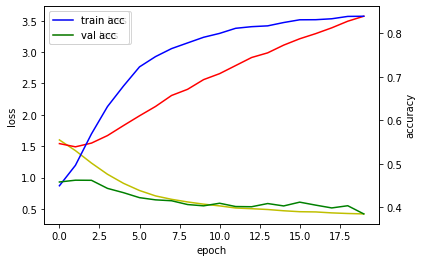

In [25]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [27]:
def inttolabel(idx):
    return {0:'non-neutral',
             1:'neutral', 
             2:'joy',
             3:'sadness',
             4:'fear',
             5:'anger',
             6:'surprise',
             7:'disgust'}[idx]

def predict(text): 
    aa = pos_tag(word_tokenize(text))
    pp = []
    for t in aa:
        pp.append("/".join(t))
    wids = [word2index[word] for word in pp]
    x_predict = pad_sequences([wids], maxlen=maxlen) 
    y_predict = model.predict(x_predict) 
    c = 0
    cnt = 0
    for y in y_predict[0]:
        if c < y:
            c = y
            ans = cnt
        cnt += 1
    ans = inttolabel(ans)
    return ans;

In [34]:
def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = '#' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [45]:
predict_data = pd.read_csv('data.csv')
total_length = len(predict_data)

cols = ['Id', 'Predicted']
lst = []
for index, row in predict_data.iterrows():
    printProgress(row['id'], total_length, 'Progress:', 'Complete', 1, 100)
    lst.append([row['id'], predict(row['utterance'])])

result_df = pd.DataFrame(lst, columns=cols)
print(result_df)

Progress: |####################################################################################################| 99.9% Complete        Id    Predicted
0        0      neutral
1        1      neutral
2        2        anger
3        3      neutral
4        4  non-neutral
...    ...          ...
1618  1618      neutral
1619  1619      neutral
1620  1620      neutral
1621  1621      neutral
1622  1622  non-neutral

[1623 rows x 2 columns]


In [46]:
result_df.to_csv('sample.csv', sep=',', index=False)